# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimer's Detection From MRIs Using Image Analysis </center></p>


### Table of contents:

* Import Libraries
* Read Data
* Visualization Of Dataset
* Data Augmentation
* InceptionV3 Model
* Evaluate The Model

# Import Libraries

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.9.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import  Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow 
import pickle


# Read Data

In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('../data/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('../data/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 100.00it/s]


image             label
0     ../data/Alzheimer_s Dataset\test\MildDemented\...      MildDemented
1     ../data/Alzheimer_s Dataset\test\MildDemented\...      MildDemented
2     ../data/Alzheimer_s Dataset\test\MildDemented\...      MildDemented
3     ../data/Alzheimer_s Dataset\test\MildDemented\...      MildDemented
4     ../data/Alzheimer_s Dataset\test\MildDemented\...      MildDemented
...                                                 ...               ...
6395  ../data/Alzheimer_s Dataset\train\VeryMildDeme...  VeryMildDemented
6396  ../data/Alzheimer_s Dataset\train\VeryMildDeme...  VeryMildDemented
6397  ../data/Alzheimer_s Dataset\train\VeryMildDeme...  VeryMildDemented
6398  ../data/Alzheimer_s Dataset\train\VeryMildDeme...  VeryMildDemented
6399  ../data/Alzheimer_s Dataset\train\VeryMildDeme...  VeryMildDemented

[6400 rows x 2 columns]

**plot number of samples per class**

# Dataset Visualisation

C:\Users\msi\AppData\Local\Temp\ipykernel_30248\3907037964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x=df.label,palette='Set1')


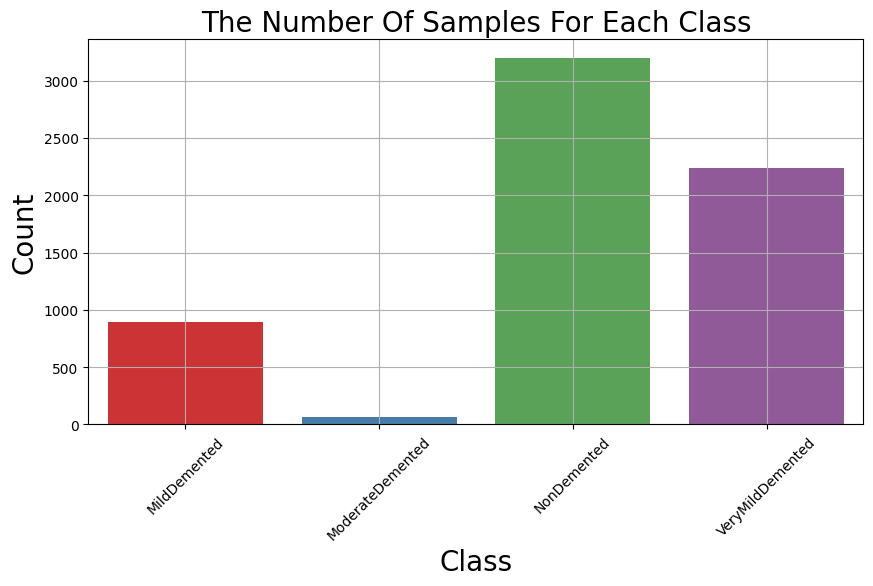

In [4]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x=df.label,palette='Set1')
plt.title('The Number Of Samples For Each Class',fontsize=20)
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Random Samples**

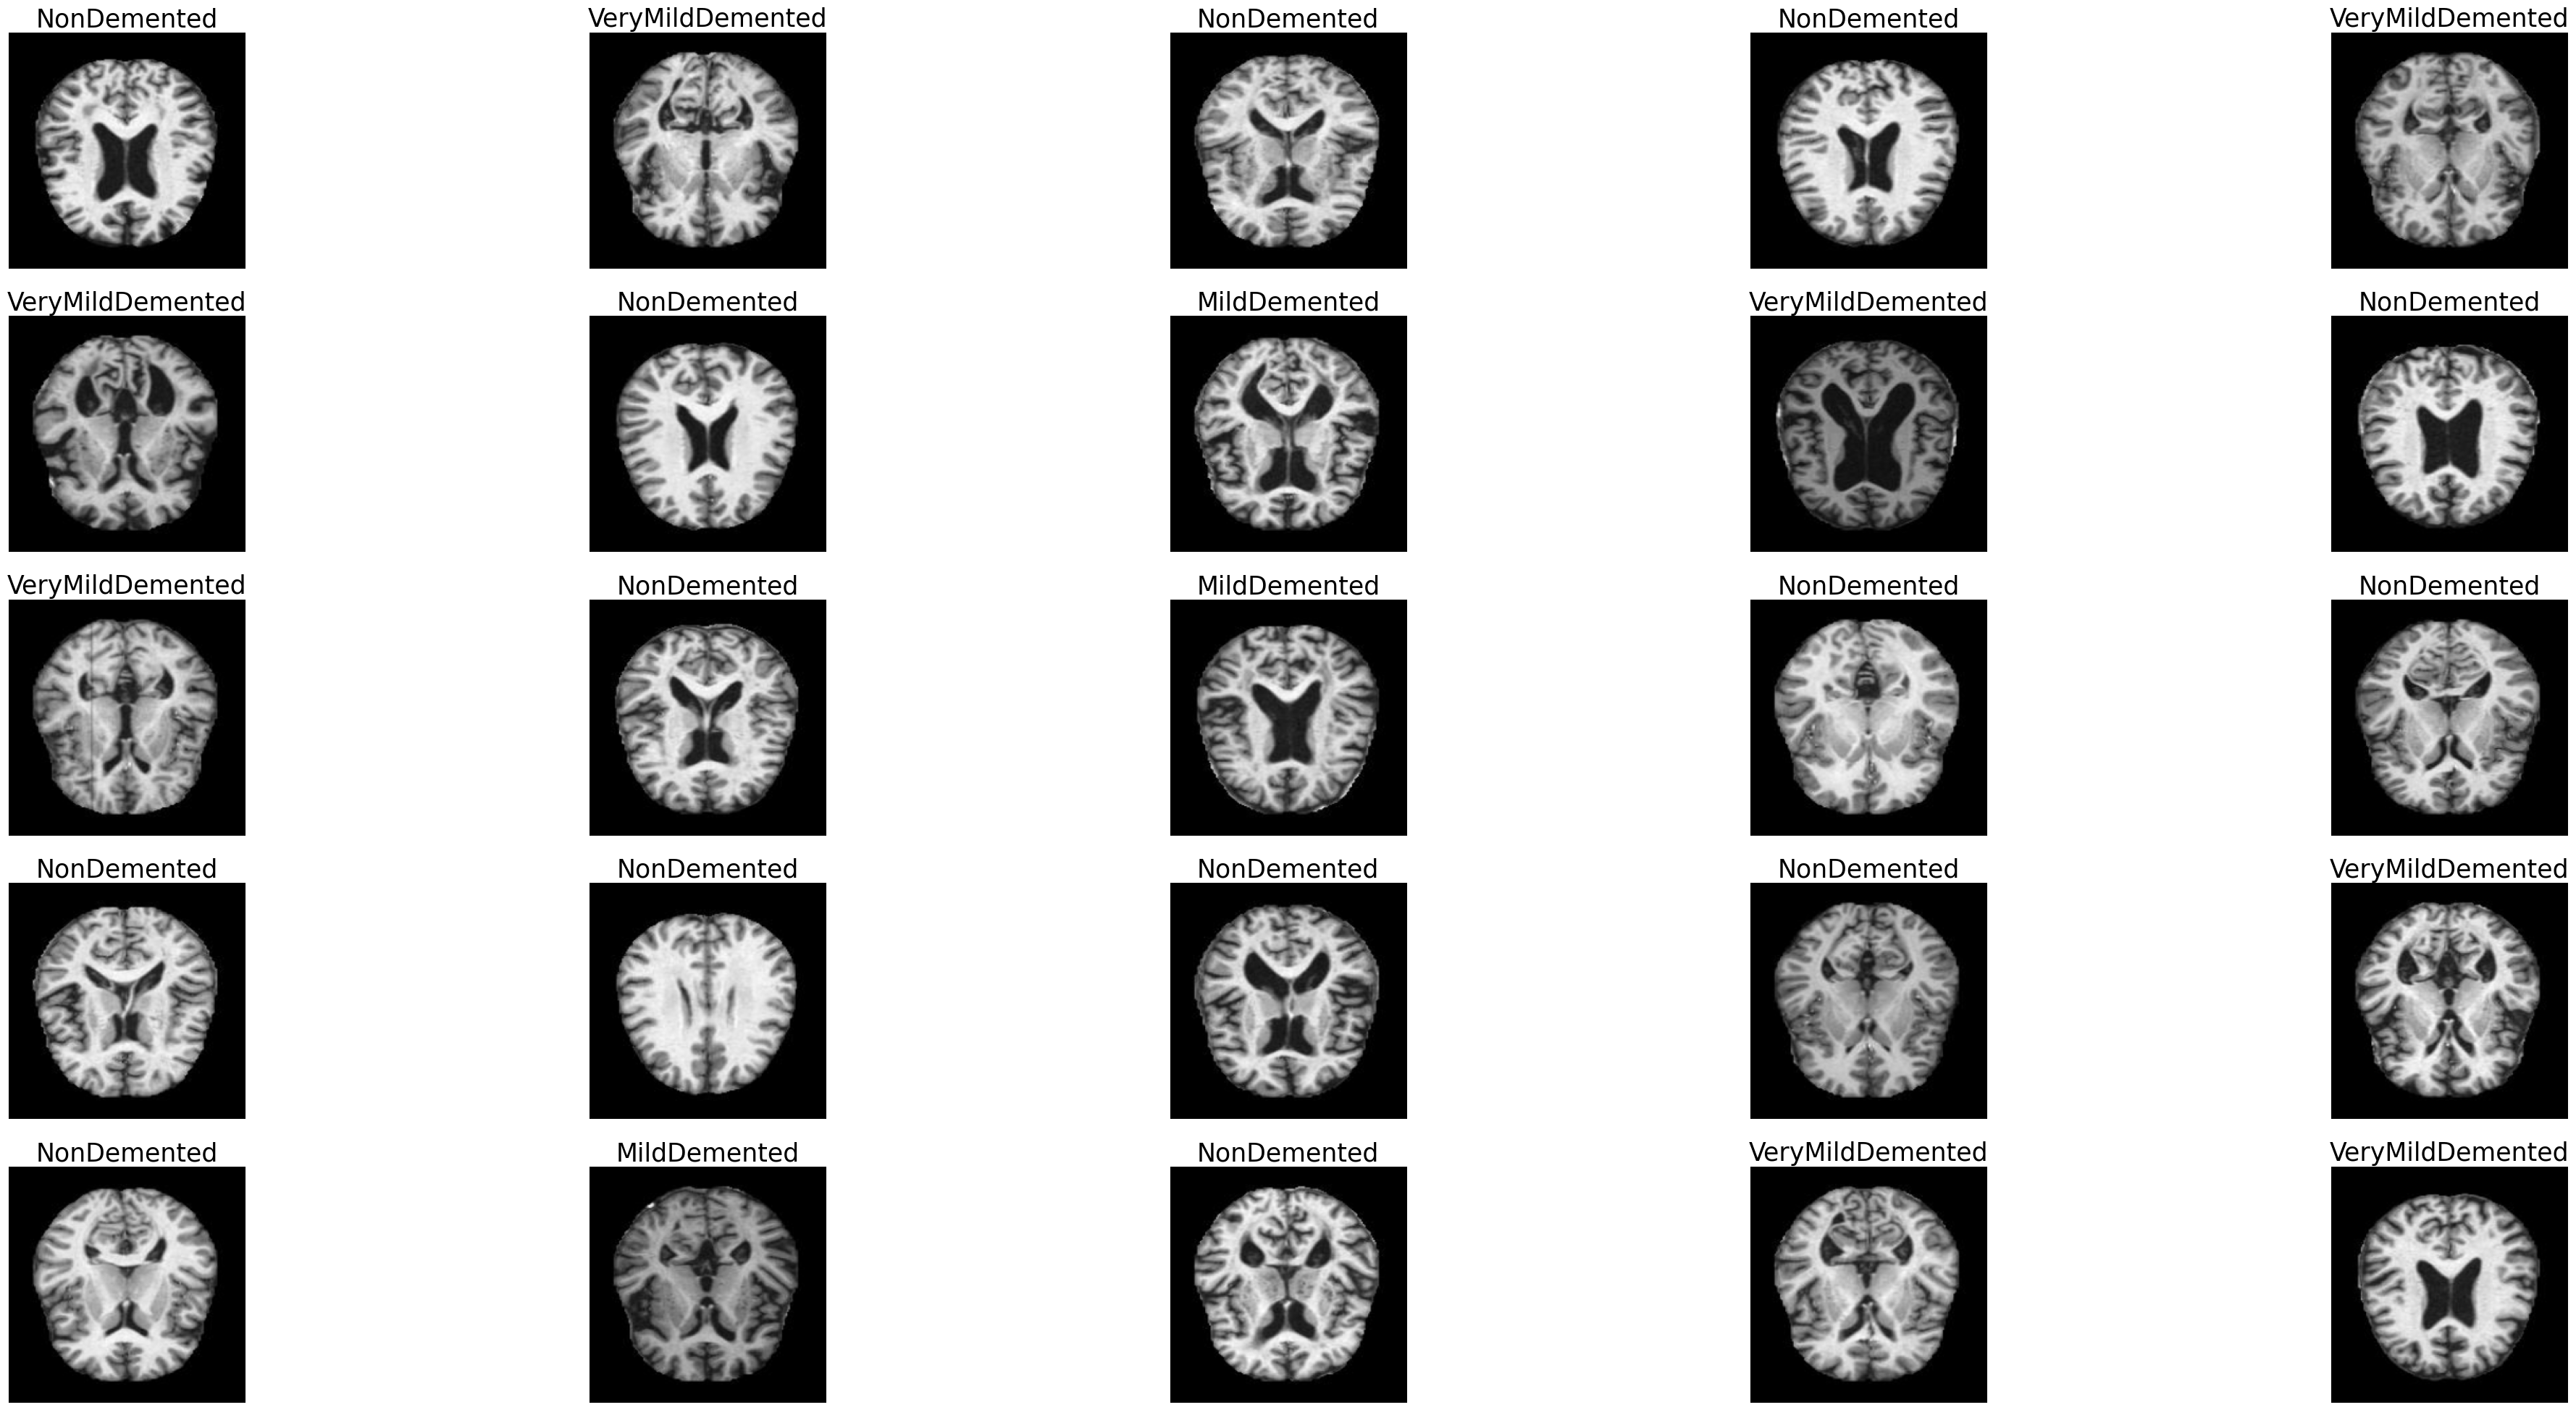

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),25)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

# Data Augmentation

In [6]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]


Found 6400 validated image filenames belonging to 4 classes.


In [7]:
train_data, train_labels = next(train_data_gen) #fetch the next batch of data and labels from the generator

In [8]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

**SMOTE** (Synthetic Minority Over-sampling Technique), which is a method used for balancing class distribution by generating synthetic samples from the minority class. 

In [9]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


C:\Users\msi\AppData\Local\Temp\ipykernel_30248\2135932548.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels,palette='Set1')


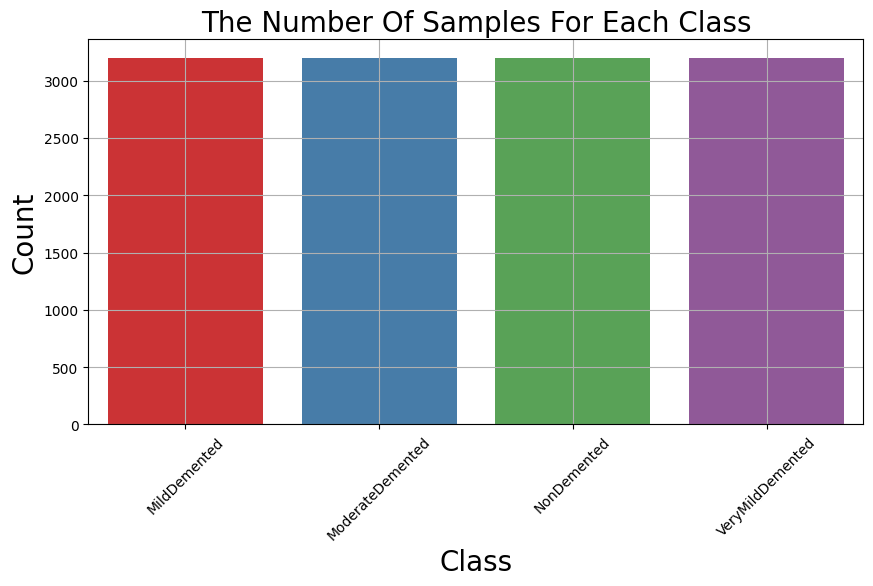

In [10]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(10,5))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Data Splitting**

train-validation-test sets (0.7 , 0.15 , 0.15)

In [11]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


# Models

# 2. ****VGG19****

* VGG19 is a convolutional neural network architecture, it is an extension of the earlier VGG16 model, with 19 layerscompared to VGG16's 16 layers. VGG19 is known for its simplicity and uniform architecture, which consists of multiple convolutional layers followed by max-pooling layers, and finally a few fully connected layers.

* VGG19 has been widely used in various computer vision tasks, including image classification, object detection, and segmentation. While it may not be the most efficient architecture in terms of computational resources, its simplicity and effectiveness make it a popular choice, especially for **transfer learning** and as a baseline for comparison with more complex models.



In [12]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 44, 128)       0     

**Compile The Model**

In [13]:
modelvgg.compile(optimizer='adam',loss=tensorflow.losses.CategoricalCrossentropy(),metrics=['acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

**Train The Model**

In [14]:
hist=modelvgg.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=callback)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Evaluate The Model

**1. During training**

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

NameError: name 'hist' is not defined

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

**2. During testing**

In [ ]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

**Prediction**

In [ ]:
predictions = modelvgg.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)


**Classification Report**

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

**Confusion Matrix**

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

# 2. ****InceptionV3****

**Transfert Learning:** InceptionV3 is a powerful convolutional neural network (CNN) trained on the ImageNet dataset. It has learned to extract hierarchical features from images. By adding custom dense layers on top of InceptionV3, you can leverage its feature extraction capabilities while adapting it to your specific task.



1. **Base Model**: `include_top=False` means that the final fully connected layers of the InceptionV3 model (which are designed for ImageNet classification) will not be included, allowing for custom classification layers to be added.

2. **Freezing Base Model Weights**: The weights of the InceptionV3 model are set to non-trainable (`base_model.trainable = False`). This means that during training, only the weights of the additional layers added on top of the InceptionV3 model will be updated, while the weights of the InceptionV3 layers themselves will remain fixed.

3. **Custom Classification Layers**: Sequential layers are added on top of the InceptionV3 base model to perform classification:
   - *Dropout layer*: Introduces regularization by randomly setting a fraction of input units to 0 at each update during training (reducing overfitting).
   - *GlobalAveragePooling2D layer*: Computes the spatial average of the entire feature map, reducing each feature map to a single value.
   - *Flatten layer*: Flattens the input to a one-dimensional array.
   - *BatchNormalization layers*: Normalizes the activations of the previous layer at each batch, stabilizing and accelerating the training process.
   - *Dense layers*: Fully connected layers with ReLU activation function.
   - *Output layer*: Dense layer with softmax activation function, producing the final output probabilities for each class.

4. **Model Summary**: The `summary()` method is called to display a summary of the model architecture, including the number of parameters in each layer.

In [15]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D()) 
model_Inception.add(keras.layers.Flatten()) 
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 512)               1

NOTE: Regularization techniques such as dropout and batch normalization can help prevent overfitting by adding noise or stabilizing activations

**Plot The Model**

In [16]:
model_Inception.predict(X_train[:1])

1/1 [==============================] - 27s 27s/step


array([[0.06431324, 0.08087783, 0.4482745 , 0.4065344 ]], dtype=float32)

In [17]:
#tf.keras.utils.plot_model(model_Inception, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

**Callbacks**

Callbacks -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

==> checkpoint_cb and early_stopping_cb

**Model Checkpoint Callback**: This callback monitors the model's performance during training and saves the model to a file (model_Inception.keras) when the validation loss decreases. The save_best_only=True parameter ensures that only the best-performing model is saved.

**Early Stopping Callback**: This callback monitors the validation loss during training and stops training if the validation loss does not improve for a certain number of epochs (patience=10). It restores the weights of the best-performing model (restore_best_weights=True) before stopping.

In [18]:
checkpoint_cb =ModelCheckpoint("model_Inception.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)

**Build The Model**

In [19]:
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Train The Model**

In [22]:
hist = model_Inception.fit(X_train,y_train,batch_size=5, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

# Evaluate The Model

**1. During Training**

In [1]:
hist_=pd.DataFrame(hist.history)
hist_

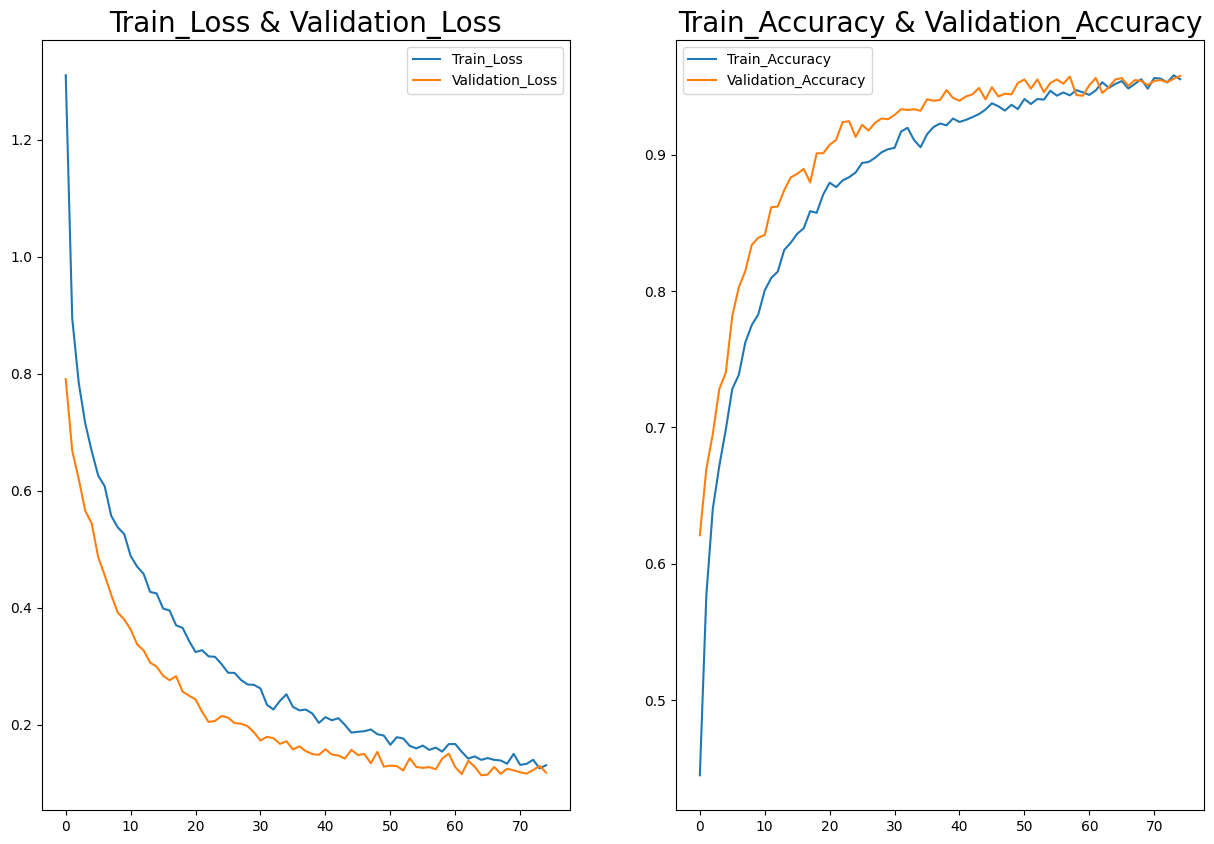

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

**2. During Testing**

In [ ]:
score, acc= model_Inception.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9322 - loss: 0.1672
Test Loss = 0.14295969903469086
Test Accuracy = 0.9437500238418579


**Prediction**

In [ ]:
predictions = model_Inception.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

 4/60 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

W0000 00:00:1711843158.409821      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

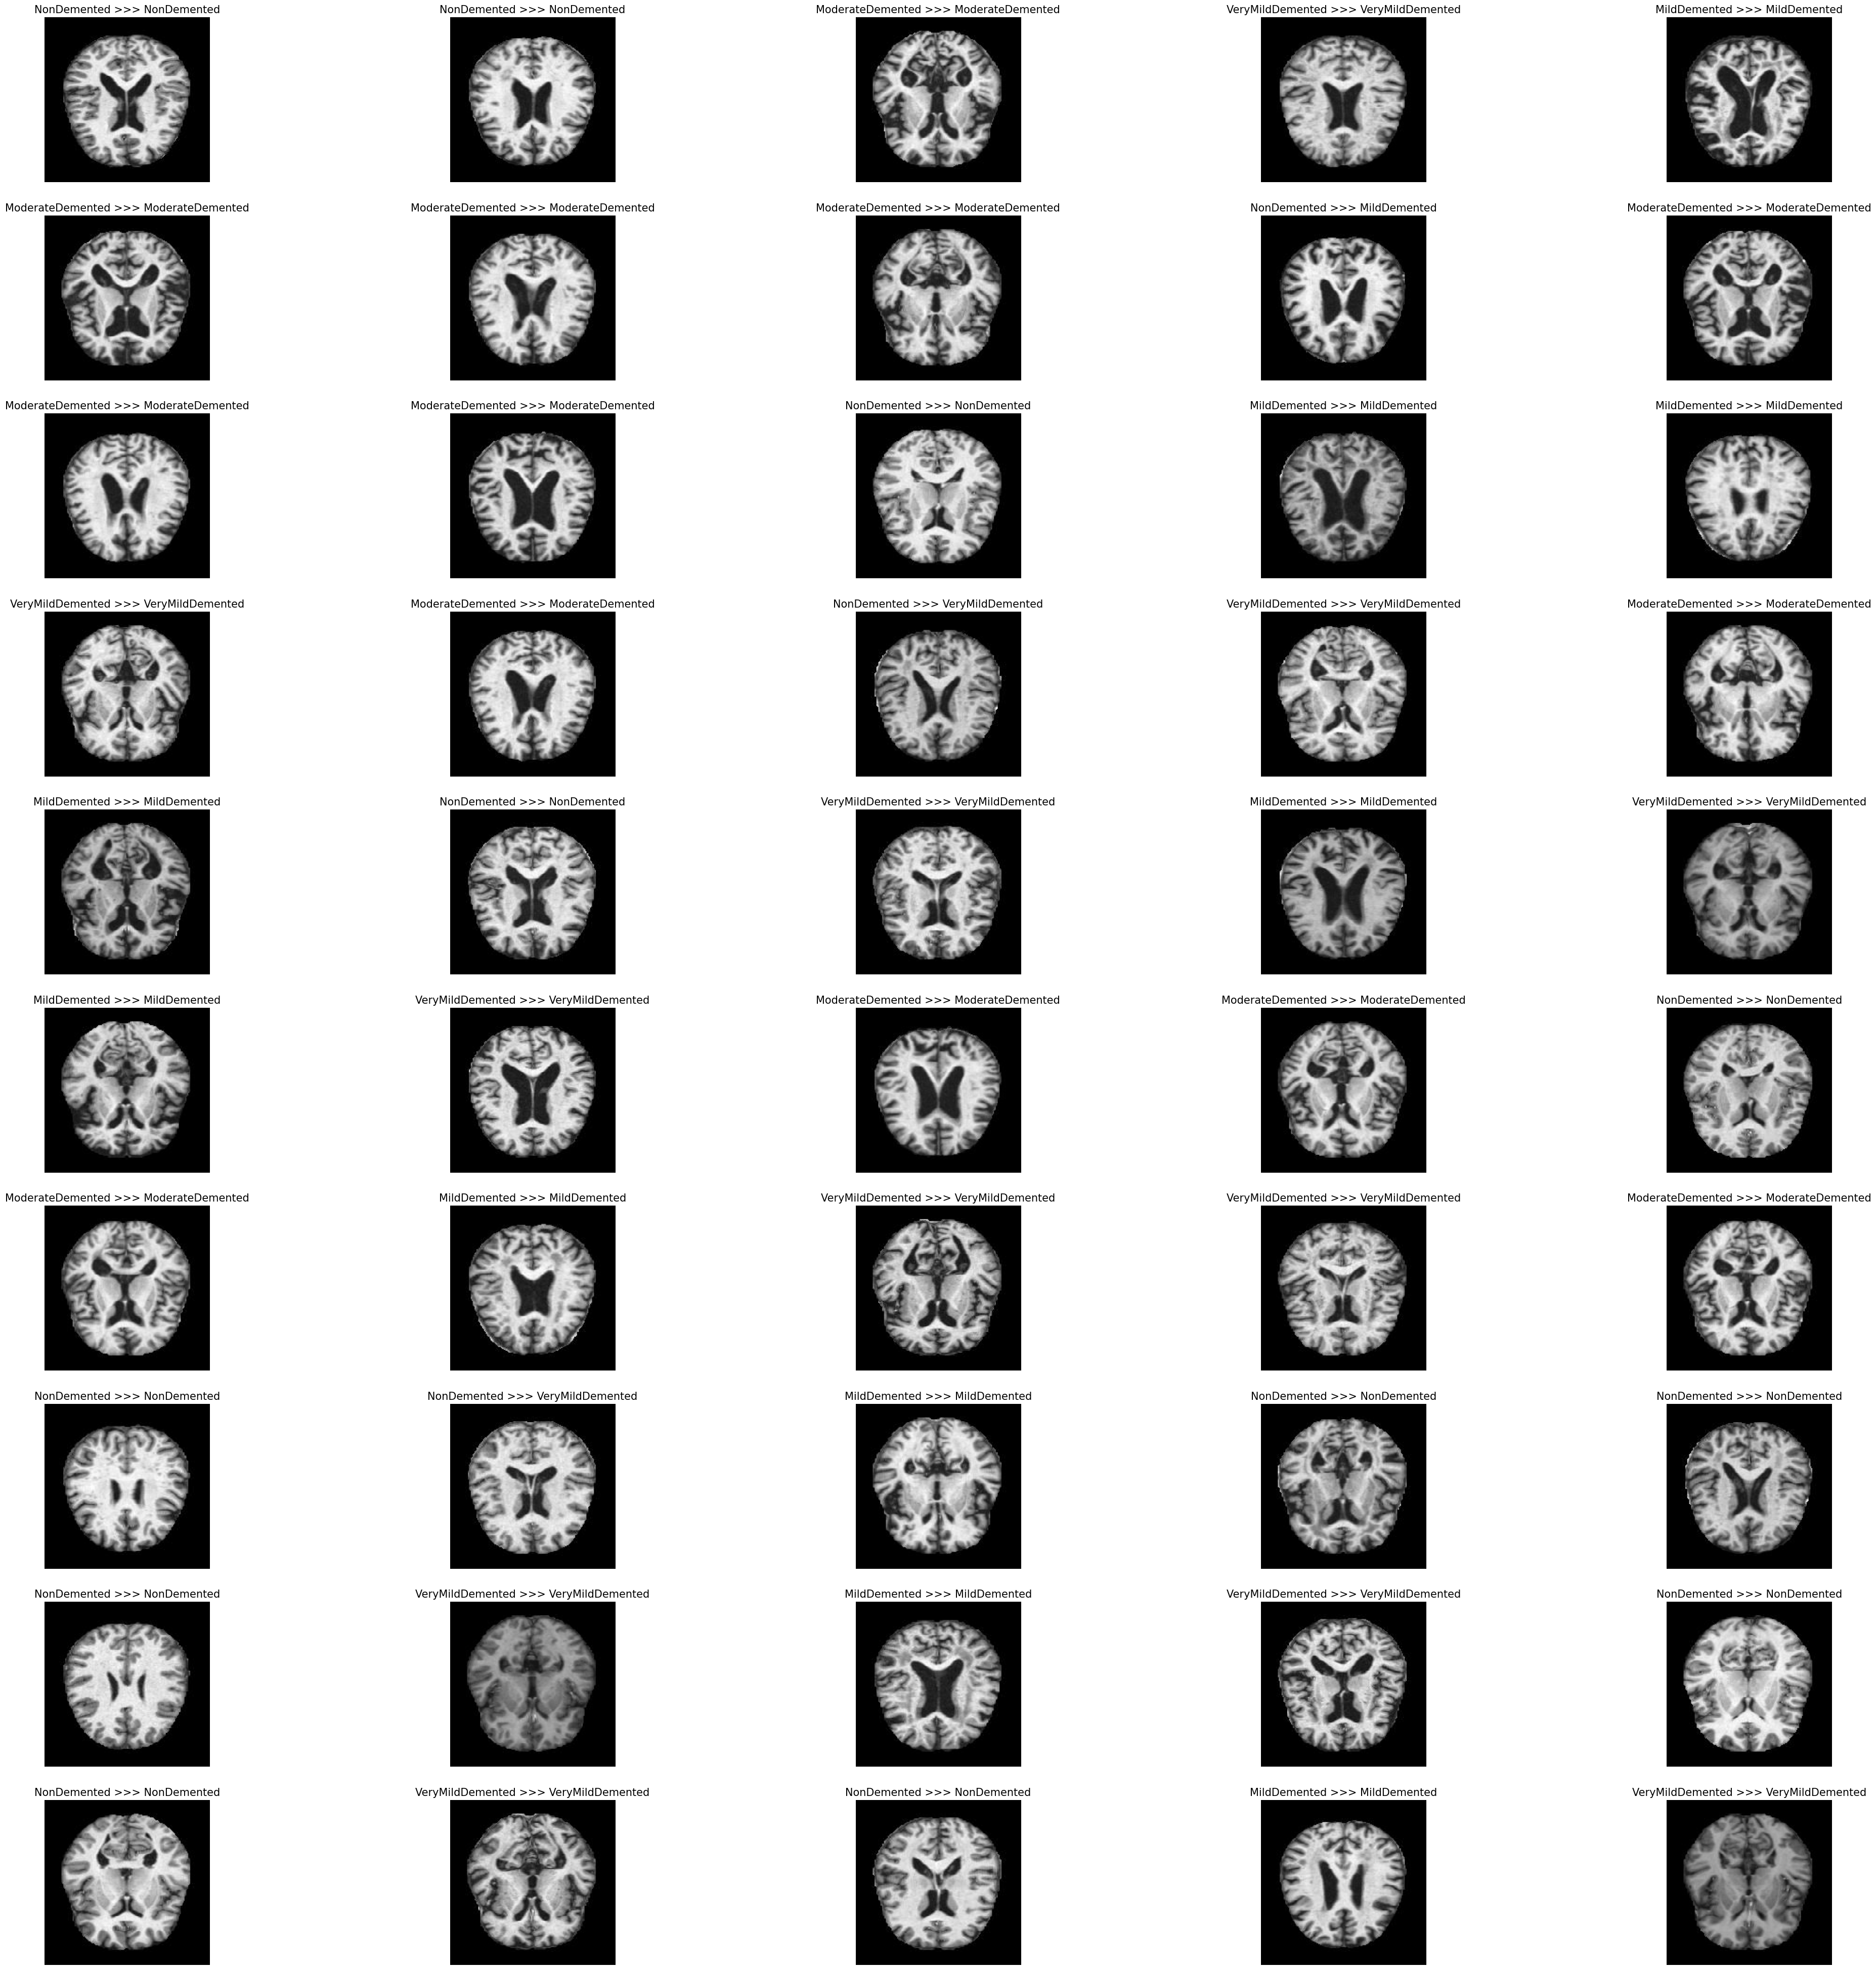

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)


**Classification Report**

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.95      0.99      0.97       480
           1       1.00      1.00      1.00       480
           2       0.92      0.89      0.90       480
           3       0.90      0.90      0.90       480

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920



**Confusion Matrix**

array([[475,   0,   1,   4],
       [  0, 480,   0,   0],
       [ 11,   0, 426,  43],
       [ 13,   0,  36, 431]])

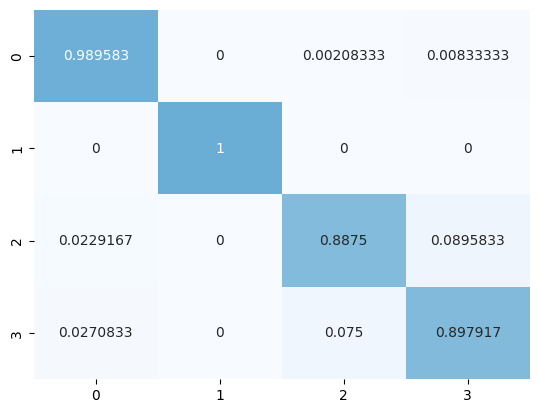

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

# Comparison & Chosen Model

* VGG9 : accuracy loss 91%
* Inception V3 : accuracy 96% 
==> chosen model: **Inception V3**

# Saving The Model

In [ ]:

# Save the model architecture and weights using Keras function
model_config = model_Inception.to_json()
with open('inception_model_config.json', 'w') as json_file:
    json_file.write(model_config)

# Save the weights
model_Inception.save_weights('inception_model.weights.h5')

# Save the entire model using pickle
with open('inception_model.pkl', 'wb') as pickle_file:
    pickle.dump(model_Inception, pickle_file)


In [ ]:
from keras.models import load_model

# Save the model
model_Inception.save('alzheimers_model.h5')

# Later, you can load the model
loaded_model = load_model('alzheimers_model.h5')
